# Présentation

Dans ce document, le but va être d'effectuer une visualisation approfondie des accidents corporels de la circulation entre 2006 et 2011.
Donnees issues de **data.gouv.fr**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

%matplotlib inline

In [13]:
df = pd.read_csv("/content/donnees_accidents.csv", encoding='latin1', on_bad_lines='skip')

/tmp/ipython-input-2777585596.py:1: DtypeWarning: Columns (15,29,31,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/donnees_accidents.csv", encoding='latin1', on_bad_lines='skip')


In [4]:
df.head()

,org,lum,agg,int,atm,col,com,dep,catr,infra,...,numero,distancemetre,libellevoie,coderivoli,grav,gps,lat,long,adr,numac
0,5,2,6,1,8.0,3.0,53,10,4.0,0.0,...,NaN,0.0,23EME R.I. ( RUE DU),NaN,0.43,NaN,NaN,NaN,NaN,1.0
1,5,1,1,1,1.0,2.0,53,10,3.0,0.0,...,NaN,NaN,NaN,NaN,0.43,NaN,NaN,NaN,NaN,2.0
2,3,3,1,1,5.0,5.0,248,10,1.0,0.0,...,NaN,0.0,A46N,NaN,0.43,NaN,NaN,NaN,NaN,3.0
3,1,3,1,1,1.0,7.0,366,10,3.0,0.0,...,NaN,NaN,NaN,NaN,0.43,NaN,0.0,0.0,NaN,4.0
4,1,1,5,1,1.0,2.0,4,10,4.0,5.0,...,NaN,NaN,NaN,NaN,0.43,NaN,0.0,0.0,NaN,5.0


## Accidents selon les conditions atmosphériques :

Nous pouvons renommer les valeurs de cette colonne selon le dictionnaire de l'**ONISR**

In [5]:
df['atm'] = df['atm'].map({
    -1: 'Non renseigné',
     1: 'Normale',
     2: 'Pluie légère',
     3: 'Pluie forte',
     4: 'Neige / grêle',
     5: 'Brouillard / fumée',
     6: 'Vent fort / tempête',
     7: 'Éblouissement',
     8: 'Temps couvert',
     9: 'Autre'
})


/tmp/ipython-input-4194402374.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='atm', data=df, order=df['atm'].value_counts().index, palette='coolwarm')


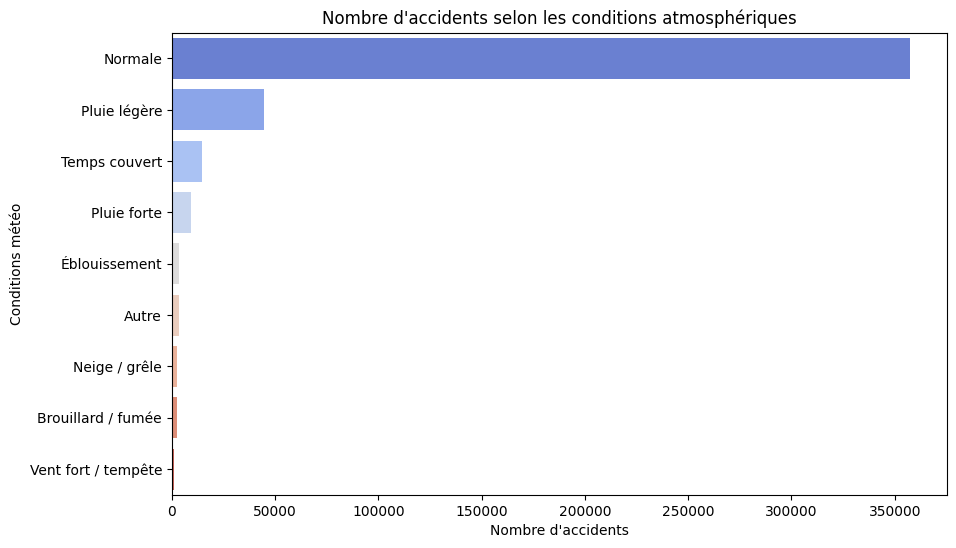

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(y='atm', data=df, order=df['atm'].value_counts().index, palette='coolwarm')
plt.title("Nombre d'accidents selon les conditions atmosphériques")
plt.xlabel("Nombre d'accidents")
plt.ylabel("Conditions météo")
plt.show()


Nous remarquons que le plus grand nombre d'accidents de la route à lieu en conditions normales, donc cette analyse n'est pas vraiment concluante pour l'instant.

## Accidents selon la luminosité :

In [7]:
df['lum'] = df['lum'].map({
     1: 'Plein jour',
     2: 'Crépuscule ou aube',
     3: 'Nuit sans éclairage de rue',
     4: 'Nuit avec éclairage de rue allumé',
     5: 'Nuit avec éclairage de rue éteint',

})

/tmp/ipython-input-3597242626.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='lum', data=df, palette='viridis')


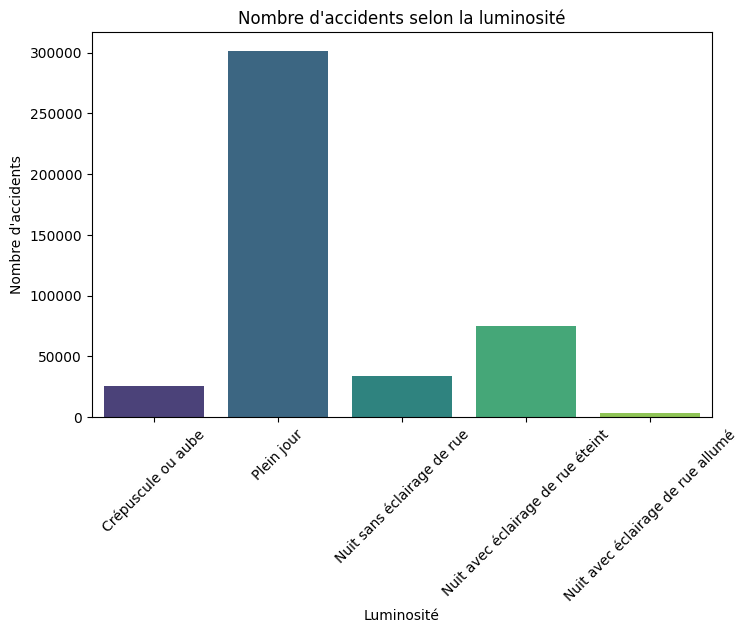

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(x='lum', data=df, palette='viridis')
plt.title("Nombre d'accidents selon la luminosité")
plt.xlabel("Luminosité")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45)
plt.show()


Comme la section d'avant, le plus grand nombre d'accident à lieu en plein jour, ce qui n'est pas concluant.

## Accidents selon les coordonnées géographiques :

In [14]:
df = df.dropna(subset=['lat', 'long'])
df= df[(df['lat'].apply(lambda x: isinstance(x, float))) &
                (df['long'].apply(lambda x: isinstance(x, float)))]
print(f"Nombre de lignes avec coordonnées valides : {len(df)}")
# Diviser par 100000 pour obtenir des degrés
df['lat'] = df['lat'] / 100000
df['long'] = df['long'] / 100000
df = df[(df['lat'] != 0) & (df['long'] != 0)]
# Vérifier
print(df[['lat', 'long']].head())


Nombre de lignes avec coordonnées valides : 149237
       lat   long
5   46.083  5.102
7   45.905  5.228
9   46.173  5.691
12  45.975  5.309
13  46.174  5.746


In [15]:
accidents = folium.Map(location=[46.6,2.4], zoom_start=6)

heat_data = [[row['lat'], row['long']] for index, row in df.iterrows()]
HeatMap(heat_data, radius=6).add_to(accidents)

accidents

Nous remarquons une plus grande concentration autour des grandes villes (Paris, Marseille).
Ceci pourrait être notamment dû à la grande présence automobile dans ces régions.

 # Analyses plus approfondies :
 Étant donné que nous n'avons pas pu retirer d'insights des paramètres de départ, nous allons tenter de déceler des résultats plus approfondis en nous posons des questions.

## Matrice de correlation
Nous allons prendre ici comme valeur cible si l'accident à engendré des morts ou non.

In [19]:
df['ttue_bin'] = df['ttue'].apply(lambda x: 1 if x > 0 else 0)

df['ttue_bin'].value_counts()


,count
ttue_bin,
0,85779
1,5177


In [20]:
cols_cat = ['atm', 'lum', 'circ']

for col in cols_cat:
    df[col + '_code'] = df[col].astype('category').cat.codes

df[['atm','atm_code','lum','lum_code','circ','circ_code']].head()


,atm,atm_code,lum,lum_code,circ,circ_code
5,5.0,4,3,2,2.0,2
7,8.0,7,1,0,1.0,1
9,1.0,0,1,0,3.0,3
12,1.0,0,2,1,1.0,1
13,1.0,0,3,2,3.0,3


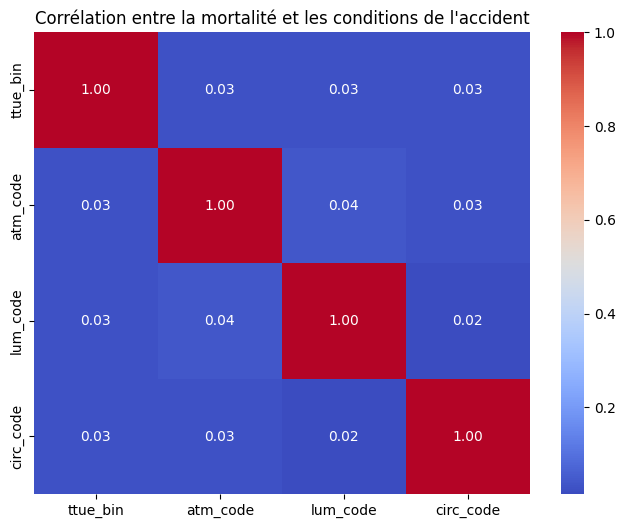

In [21]:
corr_cols = ['ttue_bin'] + [c + '_code' for c in cols_cat]
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre la mortalité et les conditions de l'accident")
plt.show()


Aucune corrélation décelée entre les conditions météo, la luminosité, le régime du traffic et la mortalité de l'accident.

## Visualisation des accidents mortels selon le type de route

In [26]:
catr_mapping = {
    1: "Autoroute",
    2: "Nationale",
    3: "Départementale",
    4: "Municipale",
    5: "Hors réseau",
    6: "Parking publique",
    7: "Route métropolitaine",
    9: "Autre"
}


In [27]:
df['catr_label'] = df['catr'].map(catr_mapping)


In [28]:
df[['catr', 'catr_label']].drop_duplicates().sort_values('catr')


,catr,catr_label
7,1.0,Autoroute
5,2.0,Nationale
91,3.0,Départementale
120,4.0,Municipale
6145,5.0,Hors réseau
456,6.0,Parking publique
175,9.0,Autre
202597,NaN,NaN


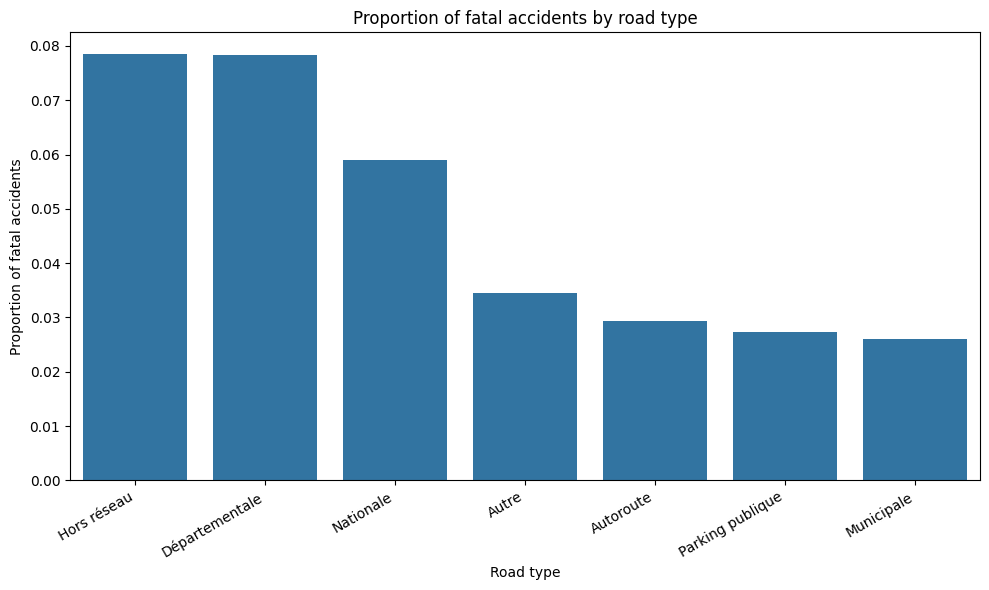

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

mort_ratio = (
    df.groupby('catr_label')['ttue_bin']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(
    x=mort_ratio.index,
    y=mort_ratio.values
)

plt.ylabel("Proportion of fatal accidents")
plt.xlabel("Road type")
plt.title("Proportion of fatal accidents by road type")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


Nous remarquons qu'il y a 2x plus de risque d'accidents dans les routes hors réseau public et les départementales, suivi par les nationales.